<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. У нас есть в распоряжении набор данных с разметкой о токсичности правок.

Метрика качества *F1* для выбранной оптимальной модели должна быть не меньше 0.75. 

**Этапы выполнения проекта:**

1. Загрузка и подготовька данных.
2. Обучение разных моделей и выбор оптимальной модели. 
3. Выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# сделаем необходимые инсталяции
!pip install nltk -q
!pip install -U lightgbm scikit-learn -q
!pip install wordcloud==1.8.2.2 -q
!pip install --upgrade Pillow==9.5.0 -q
!pip install seaborn --upgrade -q
!pip install pandas --upgrade -q
!pip install scipy==1.13.0 -q
!pip install numba --upgrade -q
!pip install numpy==1.26.4 -q
!pip install spacy -q

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import os
import re
import matplotlib.pyplot as plt
import itertools
import spacy

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PassiveAggressiveClassifier

from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [3]:
# установим опцию отображения максимальной ширины столбцов
pd.set_option('display.max_colwidth', None)

In [4]:
# загрузим необходимые элемененты библиотеки nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [5]:
# зададим стоп-слова на английском языке
stopwords = list(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

In [6]:
# установим константы
RANDOM_STATE = 1234
TEST_SIZE = 0.25

In [7]:
# загружаем данные в датафрейм
path_1 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'
path_2 = '/datasets/toxic_comments.csv'
if os.path.exists(path_1):
    toxic = pd.read_csv(path_1, index_col=0)
elif os.path.exists(path_2):
    toxic = pd.read_csv(path_2, index_col=0)
else:
    print('Something is wrong')

In [8]:
# посмотрим первые 10 строк датафрейма
toxic.head(10)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


In [9]:
# выведем общую информацию по датафрейму
toxic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [10]:
# посмотрим на распределение целевого признака
toxic['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

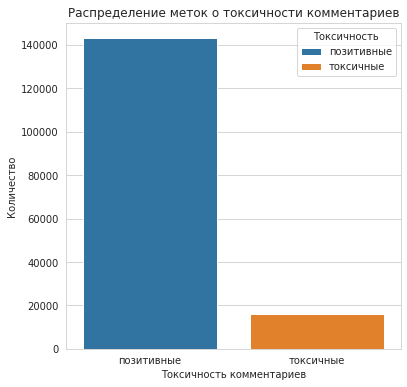

In [11]:
# построим график распределения меток о токсичности комментариев
plt.figure(figsize=(6, 6))
sns.set_style('whitegrid')
ax=sns.countplot(data=toxic, x='toxic', hue='toxic')
ax.set_xticks([0, 1])
ax.set_xticklabels(['позитивные', 'токсичные'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['позитивные', 'токсичные'], title='Токсичность')
plt.title('Распределение меток о токсичности комментариев')
plt.xlabel('Токсичность комментариев')
plt.ylabel('Количество')
plt.show()

In [12]:
# проведем регуляризацию текстов
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    j_text = " ".join(clear_text.split())
    return j_text
  
toxic['text'] = toxic['text'].apply(clear_text)

In [13]:
# создадим функцию для подсчета кол-ва слов в комментарии
def number_of_words(text):
    words_tokens = word_tokenize(text)
    number = len(words_tokens)
    return number

In [14]:
# применим функцию и добавим новый столбец с кол-вом слов в датафрейм
toxic['number_of_words'] = toxic['text'].apply(number_of_words)

In [15]:
# выведем описательную статистику по кол-ву слов по нетоксичным комментариям
toxic.query('toxic==0')['number_of_words'].describe()

count    143106.000000
mean         69.683151
std          99.659525
min           0.000000
25%          18.000000
50%          38.000000
75%          79.000000
max        1250.000000
Name: number_of_words, dtype: float64

In [16]:
# выведем описательную статистику по кол-ву слов по токсичным комментариям
toxic.query('toxic==1')['number_of_words'].describe()

count    16186.000000
mean        54.099283
std        110.071226
min          0.000000
25%         11.000000
50%         23.000000
75%         51.000000
max       1403.000000
Name: number_of_words, dtype: float64

In [17]:
# выведем строки с нулевым значением слов в комментарии
toxic.query('number_of_words==0')

,text,toxic,number_of_words
4475,,0,0
6293,,0,0
10206,,0,0
17297,,0,0
38792,,0,0
52393,,0,0
53740,,0,0
61711,,0,0
82619,,0,0
119123,,1,0


In [18]:
# удалим нулевые строки
toxic = toxic.query('number_of_words!=0')

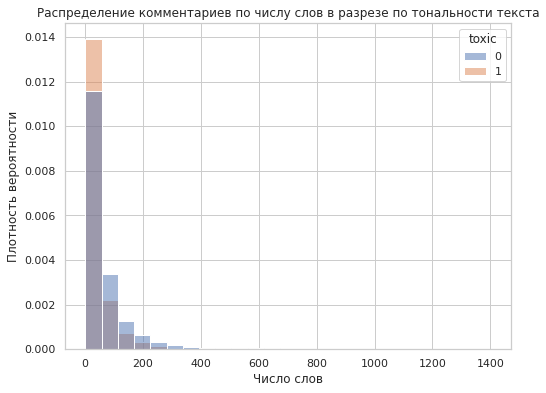

In [19]:
# построим гистограмму распределения комментариев по числу слов в разрезе по (не)токсичности текста
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')
sns.histplot(data = toxic, x = 'number_of_words', hue='toxic', bins=25,
                  stat='density', common_norm=False)
plt.title('Распределение комментариев по числу слов в разрезе по тональности текста')
plt.xlabel('Число слов')
plt.ylabel('Плотность вероятности')
plt.show()

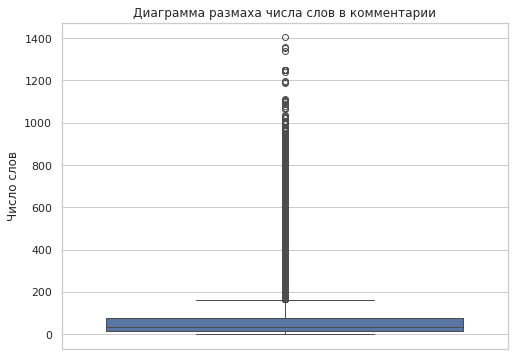

In [20]:
# построим диагамму размаха для числа слов в комментарии
plt.figure(figsize=(8, 6))
sns.boxplot(data = toxic, y = 'number_of_words')
plt.title('Диаграмма размаха числа слов в комментарии')
plt.ylabel('Число слов')
plt.show()

In [21]:
# удалим из датафрейма строки с аномальными значениями кол-ва слов в комментарии
toxic = toxic.query('number_of_words<=1000')

In [22]:
# функция для токенизации, фильтрации от стоп-слов и подготовке к подсчету частотности слов в тексте
def text_tokens(text):
    text_tokens = word_tokenize(text)
    filtered_text_tokens = [word for word in text_tokens if word not in stopwords]
    filtered_text_tokens = nltk.Text(filtered_text_tokens)
    return filtered_text_tokens

In [23]:
# применяем функцию к нетоксичным комментариям
text_tokens_pos = toxic.query('toxic==0')['text'].apply(text_tokens)

In [24]:
# считаем частотное распределение всех слов в нетоксичных комментариях
# выводим 10 самых частых слов
text_tokens_pos = list(itertools.chain(*text_tokens_pos))
fdist_pos = FreqDist(text_tokens_pos)
fdist_pos.most_common(10)

[('article', 56065),
 ('wikipedia', 44543),
 ('page', 44025),
 ('talk', 36210),
 ('please', 28711),
 ('would', 28099),
 ('one', 27410),
 ('like', 23821),
 ('see', 20516),
 ('also', 19750)]

In [25]:
# применяем функцию к токсичным комментариям
text_tokens_tox = toxic.query('toxic==1')['text'].apply(text_tokens)

In [26]:
# считаем частотное распределение всех слов в токсичных комментариях
# выводим 10 самых частых слов
text_tokens_tox = list(itertools.chain(*text_tokens_tox))
fdist_tox = FreqDist(text_tokens_tox)
fdist_tox.most_common(10)

[('fuck', 8253),
 ('wikipedia', 3927),
 ('like', 3724),
 ('shit', 3690),
 ('nigger', 3306),
 ('fucking', 3263),
 ('go', 2954),
 ('get', 2436),
 ('u', 2415),
 ('page', 2328)]

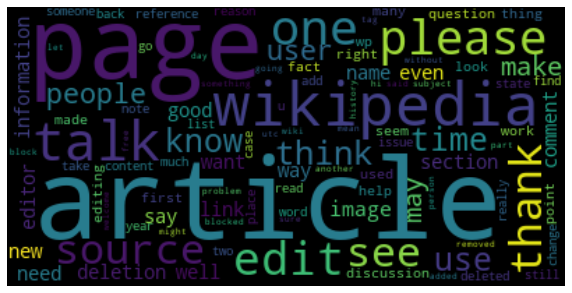

In [27]:
# выводим облако слов для нетоксичных комментариев
positive_words = " ".join(text_tokens_pos)
wordcloud_positive = WordCloud(max_words=100, collocations=False).generate(positive_words)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.show()

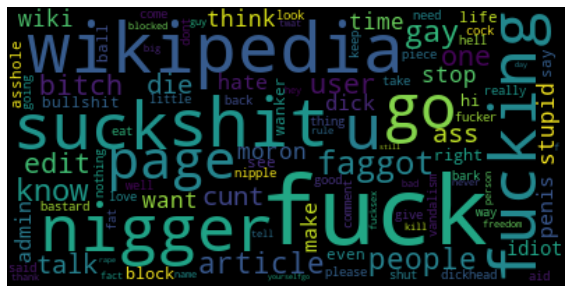

In [28]:
# выводим облако слов для токсичных комментариев
toxic_words = " ".join(text_tokens_tox)
wordcloud_toxic = WordCloud(max_words=100, collocations=False).generate(toxic_words)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_toxic, interpolation="bilinear")
plt.axis("off")
plt.show()

In [29]:
# функция для лемматизации комментариев
def lemmatize_spacy(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# применяем функцию
toxic['lemmatized_text'] = toxic['text'].apply(lemmatize_spacy)

In [30]:
# выведем первые 5 строк датафрейма
display(toxic.head())

,text,toxic,number_of_words,lemmatized_text
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,0,46,explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after I vote at new york doll fac and please don t remove the template from the talk page since I m retire now
1,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,0,16,d aww he match this background colour I m seemingly stuck with thank talk january utc
2,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0,44,hey man I m really not try to edit war it s just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page he seem to care more about the formatting than the actual info
3,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport,0,116,more I can t make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let I know there appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up it s list in the relevant form eg wikipedia good article nomination transport
4,you sir are my hero any chance you remember what page that s on,0,14,you sir be my hero any chance you remember what page that s on


In [31]:
toxic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159244 entries, 0 to 159450
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             159244 non-null  object
 1   toxic            159244 non-null  int64 
 2   number_of_words  159244 non-null  int64 
 3   lemmatized_text  159244 non-null  object
dtypes: int64(2), object(2)
memory usage: 6.1+ MB


In [32]:
# сохраняем датафрем в файл после лемматизации
toxic.to_csv('toxic_lemmatized_text.csv', encoding='utf-8')

In [33]:
# загружаем данные в датафрейм
path_1 = 'https://code.s3.yandex.net/datasets/toxic_lemmatized_text.csv'
path_2 = 'toxic_lemmatized_text.csv'
if os.path.exists(path_1):
    toxic_text = pd.read_csv(path_1, index_col=0)
elif os.path.exists(path_2):
    toxic_text = pd.read_csv(path_2, index_col=0)
else:
    print('Something is wrong')

In [34]:
# инициализируем функцию для определения настроения текста
sia = SentimentIntensityAnalyzer()

# функция для оценки негативности текста
def get_sentiment(text):

    scores = sia.polarity_scores(text)

    sentiment = 1 if scores['compound'] < -0.1 else 0

    return sentiment

# выставляем метки негативности текста, жобавляем столбец в датафрейм
toxic_text['negative_sentiment'] = toxic_text['text'].apply(get_sentiment)

In [35]:
# выводим первые 10 строк датафрейма
toxic_text.head(10)

,text,toxic,number_of_words,lemmatized_text,negative_sentiment
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,0,46,explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after I vote at new york doll fac and please don t remove the template from the talk page since I m retire now,0
1,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,0,16,d aww he match this background colour I m seemingly stuck with thank talk january utc,0
2,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0,44,hey man I m really not try to edit war it s just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page he seem to care more about the formatting than the actual info,1
3,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport,0,116,more I can t make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let I know there appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up it s list in the relevant form eg wikipedia good article nomination transport,0
4,you sir are my hero any chance you remember what page that s on,0,14,you sir be my hero any chance you remember what page that s on,0
5,congratulations from me as well use the tools well talk,0,10,congratulation from I as well use the tool well talk,0
6,cocksucker before you piss around on my work,1,8,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article has been reverted please don t do it again or you will be banned,0,21,your vandalism to the matt shirvington article have be revert please don t do it again or you will be ban,1
8,sorry if the word nonsense was offensive to you anyway i m not intending to write anything in the article wow they would jump on me for vandalism i m merely requesting that it be more encyclopedic so one can use it for school as a reference i have been to the selective breeding page but it s almost a stub it points to animal breeding which is a short messy article that gives you no info there must be someone around with expertise in eugenics,0,86,sorry if the word nonsense be offensive to you anyway I m not intend to write anything in the article wow they would jump on I for vandalism I m merely request that it be more encyclopedic so one can use it for school as a reference I have be to the selective breeding page but it s almost a stub it point to animal breeding which be a short messy article that give you no info there must be someone around with expertise in eugenic,1
9,alignment on this subject and which are contrary to those of dulithgow,0,12,alignment on this subject and which be contrary to those of duli

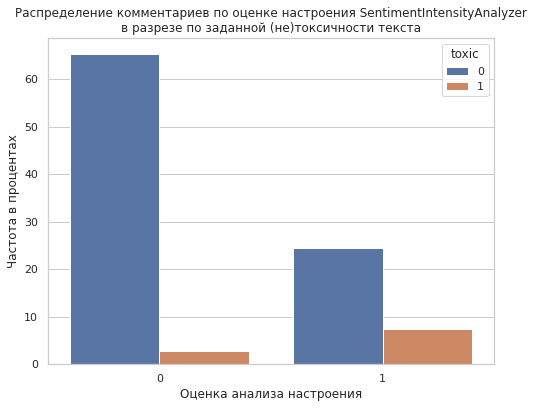

In [36]:
# строим график по меткам позитивности/негативности настроения в разрезе по заданной токсичности текста
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')
sns.countplot(data = toxic_text, x = 'negative_sentiment', hue='toxic',
                  stat='percent')
plt.title('Распределение комментариев по оценке настроения SentimentIntensityAnalyzer\nв разрезе по заданной (не)токсичности текста')
plt.xlabel('Оценка анализа настроения')
plt.ylabel('Частота в процентах')
plt.show()

**Выводы:**

Мы выгрузили данные, изучили их и выполнили подготовку данных для моделирования. Целевой признак имеет явный дисбаланс классов: токсичных комментариев на порядок меньше чем нетоксичных. Дисбаланс классов следует учесть на дальнейшем этапе выполнения задачи. Мы также посчитали кол-во слов в комментариях и вывели графики в разрезе по целевому признаку и сравнив плотности вероятиности для 2-х значений целевого признака. Мы увидели, что в среднем токсичные комментарии почти в 2 раза короче и среди них большая доля коротких комментариев по сравнению с позитивными комментариями. Мы можем сделать вывод о наличии связи длины комментария со значениями целевого признака, поэтому оставим этот новый признак для моделирования.

Кроме того мы посчитали частотут встречаемости слов по всему тексту в разрезе по целевому признаку и вывели диаграмму облака слов также в разрезе по целевому признаку. Мы видим, что для нетоксичных комментариев наиболее часто встречаемые слова: 'article', 'wikipedia', 'page', 'talk', 'please'. А наиболее часто встречемые слова среди токсичных комментариев: 'fuck' (встречается с большим перевесом по частоте), 'wikipedia', 'like', 'shit', 'nigger'.

Мы сделали обработку комментариев: убрали лишние пробелы и символы кроме латинских букв с помощью регуляризации текста, привели все буквы к нижнему регистру, затем лемматизировали с помощью инструмента SpaCy, учитывающим части речи для каждого слова. В итоге мы получили текст со словами, приведенными к единой лемматизированной форме, и очищенный от лишних символов. На следующем этапе при работе с моделями следует преобразовать его в векторные значения.

В заключении мы применили иснтрумент для анализа настроения текста SentimentIntensityAnalyzer(). На основе итоговой оценки текста - compound мы присвоили метки о позитивности/негативности текста и сравнили эти метки с метками о токсичности текста. Мы видим что метки расходятся, метка о позитивности текста для части комментариев имеет метку токсичности текста. Однако в целом среди меток негативного текста доля токсичных комментариев составляет почти треть, тогда как среди меток позитивного настроения текста доля токсичных комментариев на порядок ниже. Метки полученные с помощью SentimentIntensityAnalyzer() мы решили также использовать для моделирования.

## Обучение

In [37]:
# зададим целевой и входной признак
X = toxic_text.drop(['text', 'toxic'], axis=1)
y = toxic_text['toxic']

In [38]:
# разобъем данные на тестовоую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE,
                                                    test_size=TEST_SIZE, stratify=y)

In [39]:
num_col = ['number_of_words']

In [40]:
data_preprocessor = ColumnTransformer(transformers=
     [
         ('num', StandardScaler(), num_col),
         ('vect', TfidfVectorizer(stop_words=stopwords), 'lemmatized_text')
     ],
  remainder='passthrough'
)

In [41]:
# создаем пайплайн для подбора оптимальной модели
best_model_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LGBMClassifier())
    ]
)

In [42]:
# задаём гиперпараметры для моделей
param_gs = [
       # для модели PassiveAggressiveClassifier()
     {
        'models': [PassiveAggressiveClassifier(random_state=RANDOM_STATE)], 
        'models__max_iter': [50, 100],
        'models__C': [0.05, 0.1, 0.5]
     },
       # для модели RandomForestClassifier()
     {
        'models': [RandomForestClassifier(n_estimators=80, bootstrap=True, min_samples_leaf=2,
                                          random_state = RANDOM_STATE, class_weight='balanced_subsample',
                                          n_jobs=-1)],
        'models__max_depth': [100, 500],
        'models__min_samples_split': [10, 20],
     },

       # для модели LGBMClassifier()
     {
        'models': [LGBMClassifier(n_estimators=80, num_leaves=20, max_depth=20, 
                                  random_state = RANDOM_STATE)],
        'models__learning_rate': [0.3, 0.4]
     }

             ]

In [43]:
# инициализируем класс для автоматизированного поиска лучших гиперпараметров
# на данных кросс-валидационной выборки c помощью GridSearchCV
best_model_gs = GridSearchCV(best_model_pipe, param_grid=param_gs, cv=3, scoring='f1',
                        n_jobs=-1, verbose=3)
best_model_gs.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END models=PassiveAggressiveClassifier(random_state=1234), models__C=0.05, models__max_iter=50;, score=0.780 total time=   6.5s
[CV 2/3] END models=PassiveAggressiveClassifier(random_state=1234), models__C=0.05, models__max_iter=50;, score=0.786 total time=   6.5s
[CV 3/3] END models=PassiveAggressiveClassifier(random_state=1234), models__C=0.05, models__max_iter=50;, score=0.789 total time=   6.4s
[CV 1/3] END models=PassiveAggressiveClassifier(random_state=1234), models__C=0.05, models__max_iter=100;, score=0.780 total time=   6.5s
[CV 2/3] END models=PassiveAggressiveClassifier(random_state=1234), models__C=0.05, models__max_iter=100;, score=0.786 total time=   6.6s
[CV 3/3] END models=PassiveAggressiveClassifier(random_state=1234), models__C=0.05, models__max_iter=100;, score=0.789 total time=   6.6s
[CV 1/3] END models=PassiveAggressiveClassifier(random_state=1234), models__C=0.1, models__max_iter=50;, score=0.7

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 1/3] END models=LGBMClassifier(max_depth=20, n_estimators=80, num_leaves=20, random_state=1234), models__learning_rate=0.3;, score=0.758 total time=  40.5s
[LightGBM] [Info] Number of positive: 8077, number of negative: 71545
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 12.097202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385474
[LightGBM] [Info] Number of data points in the train set: 79622, number of used features: 7347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101442 -> initscore=-2.181306
[LightGBM] [Info] Start training from score -2.181306


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 2/3] END models=LGBMClassifier(max_depth=20, n_estimators=80, num_leaves=20, random_state=1234), models__learning_rate=0.3;, score=0.762 total time=  43.3s
[LightGBM] [Info] Number of positive: 8076, number of negative: 71546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 11.670663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 386091
[LightGBM] [Info] Number of data points in the train set: 79622, number of used features: 7381
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101429 -> initscore=-2.181444
[LightGBM] [Info] Start training from score -2.181444


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 3/3] END models=LGBMClassifier(max_depth=20, n_estimators=80, num_leaves=20, random_state=1234), models__learning_rate=0.3;, score=0.759 total time=  41.3s
[LightGBM] [Info] Number of positive: 8077, number of negative: 71545
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 11.196700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385420
[LightGBM] [Info] Number of data points in the train set: 79622, number of used features: 7353
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101442 -> initscore=-2.181306
[LightGBM] [Info] Start training from score -2.181306


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 1/3] END models=LGBMClassifier(max_depth=20, n_estimators=80, num_leaves=20, random_state=1234), models__learning_rate=0.4;, score=0.760 total time=  41.4s
[LightGBM] [Info] Number of positive: 8077, number of negative: 71545
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 12.177567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385474
[LightGBM] [Info] Number of data points in the train set: 79622, number of used features: 7347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101442 -> initscore=-2.181306
[LightGBM] [Info] Start training from score -2.181306


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 2/3] END models=LGBMClassifier(max_depth=20, n_estimators=80, num_leaves=20, random_state=1234), models__learning_rate=0.4;, score=0.763 total time=  42.4s
[LightGBM] [Info] Number of positive: 8076, number of negative: 71546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 10.785644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386091
[LightGBM] [Info] Number of data points in the train set: 79622, number of used features: 7381
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101429 -> initscore=-2.181444
[LightGBM] [Info] Start training from score -2.181444


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 3/3] END models=LGBMClassifier(max_depth=20, n_estimators=80, num_leaves=20, random_state=1234), models__learning_rate=0.4;, score=0.765 total time=  40.9s


/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['number_of_words']),
                                                                        ('vect',
                                                                         TfidfVectorizer(stop_words=['a',
                                                                                                     'about',
                                                                                                     'above',
                                                                                                     'after',
                                                                                                     'again',
                                                                                                     'against',
                                                                                                     'ain',
                                                                                                     'all',
                                                                                                     'am',
                                                                                                     'an',
                                                                                                     'and',
                                                                                                     'any',
                                                                                                     'are',
                                                                                                     'aren',
                                                                                                     "aren't",
                                                                                                     'as',
                                                                                                     'at',
                                                                                                     'be',
                                                                                                     'because',
                                                                                                     'been',
                                                                                                     'before',
                                                                                                     'being',
                                                                                                     'b...
                          'models__max_iter': [50, 100]},
                         {'models': [RandomForestClassifier(class_weight='balanced_subsample',
                                                            min_samples_leaf=2,
                                                            n_estimators=80,
                                                            n_jobs=-1,
                                                            random_state=1234)],
                          'models__max_depth': [100, 500],
                          'models__min_samples_split': [10, 20]},
                         {'models': [LGBMClassifier(max_depth=20,
                                                    n_estimators=80,
                                                    num_leaves=20,
                                                    random_state=1234)],
                          'models__learning_rate': [0.3, 0.4]}],
             scoring='f1', verbose=3)

In [44]:
# выводим лучшую обученную модель и её гиперпараметры
print('Лучшая обученная модель и её параметры:\n\n', best_model_gs.best_params_)

Лучшая обученная модель и её параметры:

 {'models': PassiveAggressiveClassifier(random_state=1234), 'models__C': 0.05, 'models__max_iter': 50}


In [45]:
# выводим общие результаты поиска гиперпараметров лучшей модели
print('\033[1mОбщие результаты поиска гиперпараметров лучшей модели:\033[0m')
display(pd.DataFrame(best_model_gs.cv_results_))

Общие результаты поиска гиперпараметров лучшей модели:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__C,param_models__max_iter,param_models__max_depth,param_models__min_samples_split,param_models__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.736950,0.035750,1.718475,0.014118,PassiveAggressiveClassifier(random_state=1234),0.05,50.0,NaN,NaN,NaN,"{'models': PassiveAggressiveClassifier(random_state=1234), 'models__C': 0.05, 'models__max_iter': 50}",0.779745,0.786171,0.788542,0.784820,0.003716,1
1,4.764927,0.078439,1.782127,0.047687,PassiveAggressiveClassifier(random_state=1234),0.05,100.0,NaN,NaN,NaN,"{'models': PassiveAggressiveClassifier(random_state=1234), 'models__C': 0.05, 'models__max_iter': 100}",0.779745,0.786171,0.788542,0.784820,0.003716,1
2,4.808306,0.131220,1.777149,0.009530,PassiveAggressiveClassifier(random_state=1234),0.10,50.0,NaN,NaN,NaN,"{'models': PassiveAggressiveClassifier(random_state=1234), 'models__C': 0.1, 'models__max_iter': 50}",0.771829,0.775019,0.780475,0.775775,0.003570,3
3,4.795292,0.160711,1.788419,0.026529,PassiveAggressiveClassifier(random_state=1234),0.10,100.0,NaN,NaN,NaN,"{'models': PassiveAggressiveClassifier(random_state=1234), 'models__C': 0.1, 'models__max_iter': 100}",0.771829,0.775019,0.780475,0.775775,0.003570,3
4,4.635937,0.100688,1.791826,0.017665,PassiveAggressiveClassifier(random_state=1234),0.50,50.0,NaN,NaN,NaN,"{'models': PassiveAggressiveClassifier(random_state=1234), 'models__C': 0.5, 'models__max_iter': 50}",0.755370,0.748358,0.753898,0.752542,0.003019,7
5,4.655389,0.102086,1.747241,0.017551,PassiveAggressiveClassifier(random_state=1234),0.50,100.0,NaN,NaN,NaN,"{'models': PassiveAggressiveClassifier(random_state=1234), 'models__C': 0.5, 'models__max_iter': 100}",0.755370,0.748358,0.753898,0.752542,0.003019,7
6,28.328569,0.571685,2.941843,0.021671,"RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,\n n_estimators=80, n_jobs=-1, random_state=1234)",NaN,NaN,100.0,10.0,NaN,"{'models': RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2, n_estimators=80, n_jobs=-1, random_state=1234), 'models__max_depth': 100, 'models__min_samples_split': 10}",0.627742,0.632594,0.615854,0.625397,0.007032,11
7,25.795121,0.823698,2.884544,0.060945,"RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,\n n_estimators=80, n_jobs=-1, random_state=1234)",NaN,NaN,100.0,20.0,NaN,"{'models': RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2, n_estimators=80, n_jobs=-1, random_state=1234), 'models__max_depth': 100, 'models__min_samples_split': 20}",0.621285,0.635508,0.616524,0.624439,0.008065,12
8,39.588946,0.155453,3.726717,0.009602,"RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,\n n_estimators=80, n_jobs=-1, random_state=1234)",NaN,NaN,500.0,10.0,NaN,"{'models': RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2, n_estimators=80, n_jobs=-1, random_state=1234), 'models__max_depth': 500, 'models__min_samples_split': 10}",0.676117,0.697809,0.694448,0.689458,0.009533,10
9,37.964377,0.058505,3.702043,0.054987,"RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,\n n_estimators=80, n_jobs=-1, random_state=1234)",NaN,NaN,500.0,20.0,NaN,"{'models': RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2, n_estimators=80, n_jobs=-1, random_state=1234), 'models__max_depth': 500, 'models__min_samples_split': 20}",0.675214,0.695935,0.697775,0.689641,0.010229,9


In [46]:
# сделаем предсказания целевого признака с помощью лучшей модели на тестовой выборки
predictions = best_model_gs.predict(X_test)
print('Значением метрики качества F1 для лучшей модели на тестовой выборке:',
      round(f1_score(y_test, predictions), 2))

Значением метрики качества F1 для лучшей модели на тестовой выборке: 0.79


In [47]:
# выводим трансформированные признаки из data_preprocessor и их важность для целевого признака
print('Важность входных признаков для лучшей модели:')
pd.DataFrame({
    'Feature_name':
    best_model_gs.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
    'Importance':
    np.around(best_model_gs.best_estimator_.named_steps['models'].coef_[0],
              decimals=2)
           }).sort_values(by='Importance', ascending=False).head(50)

Важность входных признаков для лучшей модели:


,Feature_name,Importance
42009,vect__fuck,16.23
42037,vect__fucking,12.28
101540,vect__shit,9.50
52318,vect__idiot,9.14
12796,vect__bitch,8.90
7617,vect__asshole,8.67
15884,vect__bullshit,8.37
38016,vect__faggot,8.29
7537,vect__ass,7.75
107877,vect__suck,7.61


## Выводы 

На этапе  предобработки выгрузили данные и выполнили подготовку данных для моделирования. Мы регулизировали и лемматизировали комментарии, удалили комментарии с нулевым кол-вом слов и с аномально высоким кол-вом слов. Мы также добавили новые признаки, которые решено использорвать для моделирования: длину слов в комментарии и оценку позитивности/негативности текста, полученную с помощью SentimentIntensityAnalyzer(). Мы увидели, что в среднем токсичные комментарии почти в 2 раза короче и среди них большая доля коротких комментариев по сравнению с позитивными комментариями, что говорит о наличии связи между длиной комментария со значениями целевого признака. Среди комментариев с метками негативного текста SentimentIntensityAnalyzer() доля токсичных комментариев составляет почти треть, тогда как среди комментариев с метками позитивного настроения текста доля токсичных комментариев очень незначительная.

На этапе обучения мы прежде всего определили входной и целевой признак для моделирования, а затем провели разбивку данных на тренировочную и тестовую выборки, применив стратификацию по целевому признаку, чтобы таким образом учесть дисбаланс классов при обучении и получить лучшее качество модели.

Мы выбрали 3 модели для нашей задачи классификации - определения тональности текст: PassiveAggressiveClassifier(), RandomForestClassifier(), LGBMClassifier(). Подготовку данных, выбор оптимальных гиперпараметров и обучение выбранной оптимальной модели мы выполнили в пайплайне, использовав GridSearchCV для подбора оптимальных гиперпараметров. В пайплайн мы включили предобработку количественных данных (длина текста) с помощью StandardScaler и векторизацию лемматизированного текста, подготовленного на предыдущем этапе, с помощью инструмента TfidfVectorizer. Метрику качества F1 мы считали на кросс-валидационной выборке и с помощью GridSearchCV отобрали модель с лучшим показателем заданной метрики. Мы вывели общие результаты поиска гиперпараметров лучшей модели, чтобы посмотреть как справились наши модели с задачей классификации.

Мы видим, что модель RandomForestClassifier() показывает самые низкие значения метрики F1: менее 0.7. Модель RandomForestClassifier() имеет большую сложность за счёт использования большого значения максимальной глубины и работает довольно медленно, хотя и быстрее чем LGBMClassifier(). С помощью модели LGBMClassifier() мы получили метрику качества F1 выше 0.75. При этом модель работает медленнее других моделей и почти в 10 раз медленнее оьбучается на кросс-валидационной выборке по сравнению с моделью PassiveAggressiveClassifier(). Модель PassiveAggressiveClassifier() показывает лучшее значение метрики F1=0.78 на тренировочной выборке. Оптимальные параметры для модели PassiveAggressiveClassifier(): C=0.05, max_iter=50. Кроме того модель работает очень быстро, обучается на порядок быстрее чем RandomForestClassifier() и LGBMClassifier().

В заключение мы посчитали метрику F1 для лучшей выбранной модели PassiveAggressiveClassifier() на тестовой выборке и получили значение 0.79. Полученное значение метрики удовлетворяет цели поставленной задачи. Также мы вывели 50 первых входных признаков по важности, мы увидели слова, указывающие на токсичность комментария.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны